In [1]:
from kan import KAN
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt 


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype = torch.get_default_dtype()

In [2]:
class Args:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

# Dataset Args
n_classes = 3 #2**2
m = 10
n_epochs = 100
hidden = [5]*5
architecture = [2] + hidden + [n_classes]

print(architecture)



args_dict = {
    'seed': 0,
    'base_fun': "silu",
    'kan_architecture': architecture,
    'grid': 5,
    'k': 3,
    'bounds': (-1,1),
    'learning_rate': 1e-3,
}
args = Args(**args_dict)

[2, 5, 5, 5, 5, 5, 3]


In [3]:
def spiral_data(n_samples=1000, n_classes=3, noise=0.5, seed=0, device="cpu"):
    np.random.seed(seed)
    X = []
    y = []
    samples_per_class = n_samples // n_classes
    for class_num in range(n_classes):
        ix = np.linspace(0, 1, samples_per_class)
        r = ix
        t = class_num * 4 + ix * 4 * np.pi + np.random.randn(samples_per_class) * noise
        x1 = r * np.sin(t)
        x2 = r * np.cos(t)
        X.append(np.c_[x1, x2])
        y.append(np.full(samples_per_class, class_num))
    X = np.concatenate(X)
    y = np.concatenate(y)
    # Shuffle the data
    idx = np.random.permutation(len(X))
    X = X[idx]
    y = y[idx]
    # Split into train/test (50/50)
    split = len(X) // 2
    train_input, test_input = X[:split], X[split:]
    train_label, test_label = y[:split], y[split:]
    dtype = torch.get_default_dtype()
    dataset = {}
    dataset['train_input'] = torch.from_numpy(train_input).type(dtype).to(device)
    dataset['test_input'] = torch.from_numpy(test_input).type(dtype).to(device)
    dataset['train_label'] = torch.from_numpy(train_label).type(torch.long).to(device)
    dataset['test_label'] = torch.from_numpy(test_label).type(torch.long).to(device)
    return dataset

dataset = spiral_data(n_samples=1000, n_classes=n_classes, noise=0.0, seed=42, device=device)

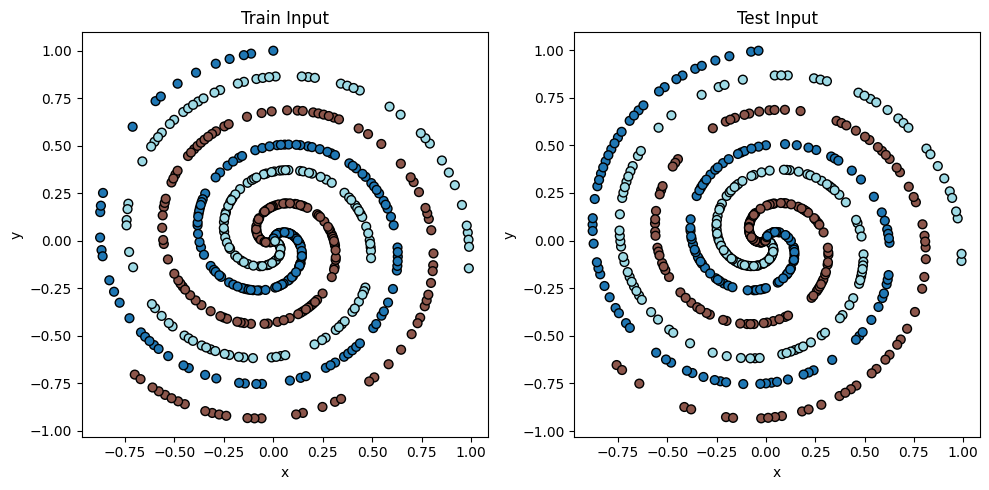

In [4]:

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot train input
axs[0].scatter(dataset['train_input'][:, 0].cpu(), dataset['train_input'][:, 1].cpu(),
               c=dataset['train_label'].cpu(), cmap='tab20', edgecolor='k', s=40)
axs[0].set_title('Train Input')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

# Plot test input
axs[1].scatter(dataset['test_input'][:, 0].cpu(), dataset['test_input'][:, 1].cpu(),
               c=dataset['test_label'].cpu(), cmap='tab20', edgecolor='k', s=40)
axs[1].set_title('Test Input')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')

plt.tight_layout()
plt.show()

In [5]:
class ReLUMLP(nn.Module):
    def __init__(self, n_hidden=32, n_classes=2, depth=3):
        super().__init__()
        layers = [nn.Linear(2, n_hidden), nn.ReLU()]
        for _ in range(depth - 1):
            layers.append(nn.Linear(n_hidden, n_hidden))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(n_hidden, n_classes))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

mlp = ReLUMLP(n_hidden=16, n_classes=n_classes, depth=3).to(device)
print("MLP")
print(mlp)

MLP
ReLUMLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=3, bias=True)
  )
)


# Normal MLP & KAN Training

In [6]:
import torch.nn.functional as F

def train_model(model, optimizer, dataset, n_epochs=100, log_interval=10):
    train_input = dataset['train_input']
    train_label = dataset['train_label']
    test_input = dataset['test_input']
    test_label = dataset['test_label']

    train_accs, test_accs, train_losses, test_losses = [], [], [], []

    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(train_input)
        loss = F.cross_entropy(output, train_label)
        loss.backward()
        optimizer.step()

        # Logging
        model.eval()
        with torch.no_grad():
            train_pred = model(train_input).argmax(dim=1)
            test_pred = model(test_input).argmax(dim=1)
            train_acc = (train_pred == train_label).float().mean().item()
            test_acc = (test_pred == test_label).float().mean().item()
            train_loss = F.cross_entropy(model(train_input), train_label).item()
            test_loss = F.cross_entropy(model(test_input), test_label).item()
            train_accs.append(train_acc)
            test_accs.append(test_acc)
            train_losses.append(train_loss)
            test_losses.append(test_loss)
        if (epoch+1) % log_interval == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{n_epochs} | Train Acc: {train_acc:.3f} | Test Acc: {test_acc:.3f} | Train Loss: {train_loss:.3f} | Test Loss: {test_loss:.3f}")

    return {
        'train_accs': train_accs,
        'test_accs': test_accs,
        'train_loss': train_losses,
        'test_loss': test_losses
    }


In [7]:
# Train MLP
mlp_opt = torch.optim.Adam(mlp.parameters(), lr=args.learning_rate)
mlp_logs = train_model(mlp, mlp_opt, dataset, n_epochs=n_epochs)

Epoch 1/100 | Train Acc: 0.341 | Test Acc: 0.326 | Train Loss: 1.101 | Test Loss: 1.105
Epoch 10/100 | Train Acc: 0.341 | Test Acc: 0.326 | Train Loss: 1.099 | Test Loss: 1.103
Epoch 20/100 | Train Acc: 0.341 | Test Acc: 0.326 | Train Loss: 1.098 | Test Loss: 1.101
Epoch 30/100 | Train Acc: 0.363 | Test Acc: 0.344 | Train Loss: 1.096 | Test Loss: 1.099
Epoch 40/100 | Train Acc: 0.343 | Test Acc: 0.334 | Train Loss: 1.095 | Test Loss: 1.097
Epoch 50/100 | Train Acc: 0.357 | Test Acc: 0.350 | Train Loss: 1.094 | Test Loss: 1.096
Epoch 60/100 | Train Acc: 0.411 | Test Acc: 0.340 | Train Loss: 1.092 | Test Loss: 1.094
Epoch 70/100 | Train Acc: 0.373 | Test Acc: 0.324 | Train Loss: 1.090 | Test Loss: 1.092
Epoch 80/100 | Train Acc: 0.419 | Test Acc: 0.380 | Train Loss: 1.087 | Test Loss: 1.090
Epoch 90/100 | Train Acc: 0.423 | Test Acc: 0.390 | Train Loss: 1.084 | Test Loss: 1.087
Epoch 100/100 | Train Acc: 0.421 | Test Acc: 0.392 | Train Loss: 1.081 | Test Loss: 1.084


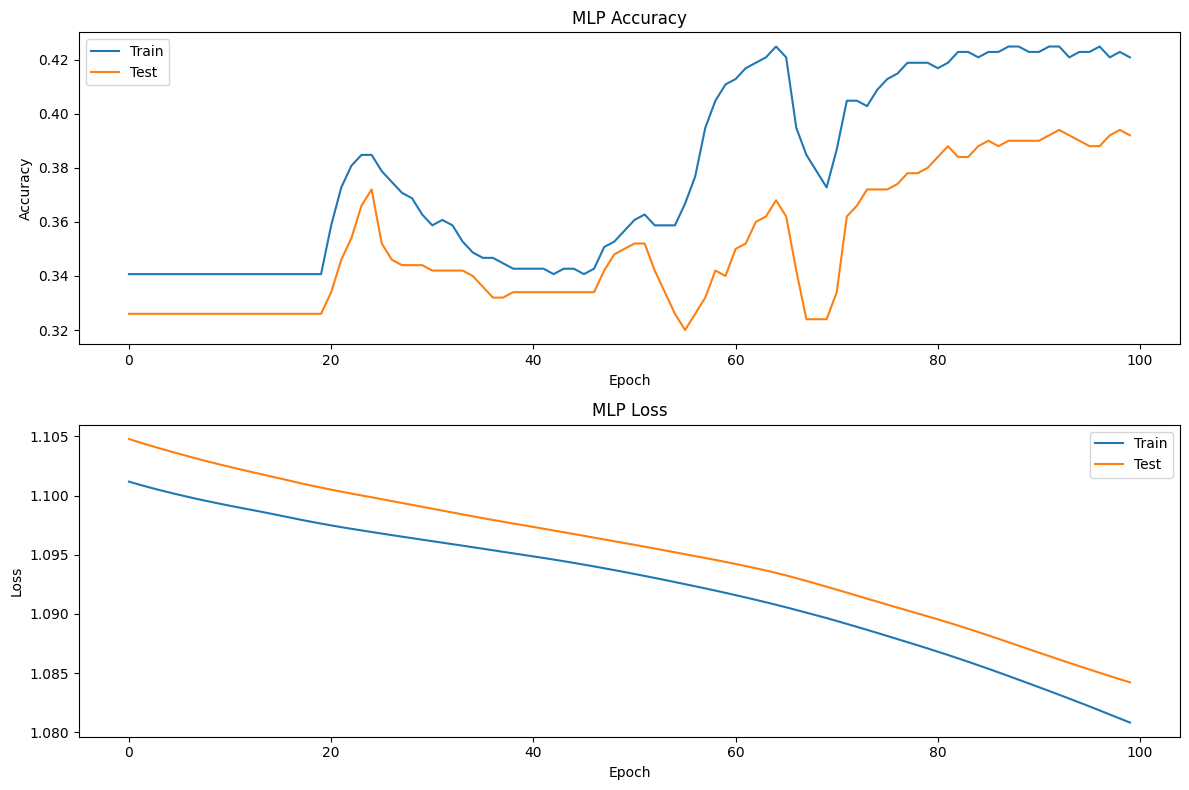

In [8]:

# Plotting
fig, axs_plot = plt.subplots(2, 1, figsize=(12, 8))

# KAN plots
axs_plot[0].plot(mlp_logs['train_accs'], label='Train')
axs_plot[0].plot(mlp_logs['test_accs'], label='Test')
axs_plot[0].set_title('MLP Accuracy')
axs_plot[0].set_xlabel('Epoch')
axs_plot[0].set_ylabel('Accuracy')
axs_plot[0].legend()

axs_plot[1].plot(mlp_logs['train_loss'], label='Train')
axs_plot[1].plot(mlp_logs['test_loss'], label='Test')
axs_plot[1].set_title('MLP Loss')
axs_plot[1].set_xlabel('Epoch')
axs_plot[1].set_ylabel('Loss')
axs_plot[1].legend()

plt.tight_layout()
plt.show()

In [9]:
# Create a mesh grid over the input space
xx, yy = np.meshgrid(
    np.linspace(-1.1 , 1.1, 300),
    np.linspace(-1.1 , 1.1, 300)
)
grid = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.from_numpy(grid).type(dtype).to(device)


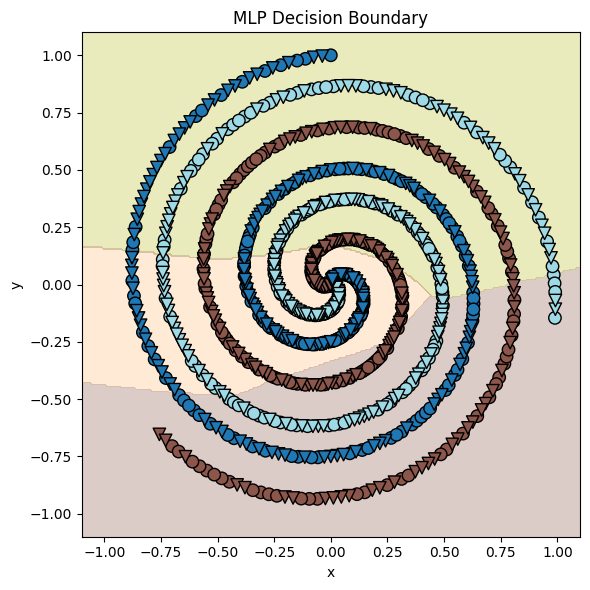

In [10]:
# Evaluate kan_layerwise on the grid
mlp.eval()
with torch.no_grad():
    mlp_pred = mlp(grid_tensor).argmax(dim=1).cpu().numpy().reshape(xx.shape)

plt.figure(figsize=(6, 6))
plt.contourf(xx, yy, mlp_pred, alpha=0.3, levels=n_classes-1, cmap='tab20')
plt.scatter(dataset['train_input'][:, 0].cpu(), dataset['train_input'][:, 1].cpu(), 
            c=dataset['train_label'].cpu(), cmap='tab20', edgecolor='k', s=80, marker='o', label='Train Data (o)')
plt.scatter(dataset['test_input'][:, 0].cpu(), dataset['test_input'][:, 1].cpu(), 
            c=dataset['test_label'].cpu(), cmap='tab20', edgecolor='k', s=80, marker='v', label='Test Data (v)')
plt.title('MLP Decision Boundary')
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()

In [11]:
kan = KAN(
    width=args.kan_architecture,
    device=device,
    grid=args.grid, k=args.k, #seed=0,
    #init_mode='kaiming_in',
    base_fun=args.base_fun,
    )
print("KAN")
print(kan)

_ = kan(dataset['train_input'])

checkpoint directory created: ./model
saving model version 0.0
KAN
MultKAN(
  (act_fun): ModuleList(
    (0-5): 6 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-5): 6 x Symbolic_KANLayer()
  )
)


In [12]:
def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).float())

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).float())

# Train KAN
kan_opt = torch.optim.Adam(kan.parameters(), lr=args.learning_rate)
#kan_logs = train_model(kan, kan_opt, dataset, n_epochs=n_epochs)

metrics = (train_acc, test_acc)

kan_logs = kan.fit(dataset,
                   opt="Adam",
                   lr=args.learning_rate,
                   steps=n_epochs,
                   metrics=metrics
                   )

description:   0%|                                                          | 0/100 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (3) must match the size of tensor b (499) at non-singleton dimension 1

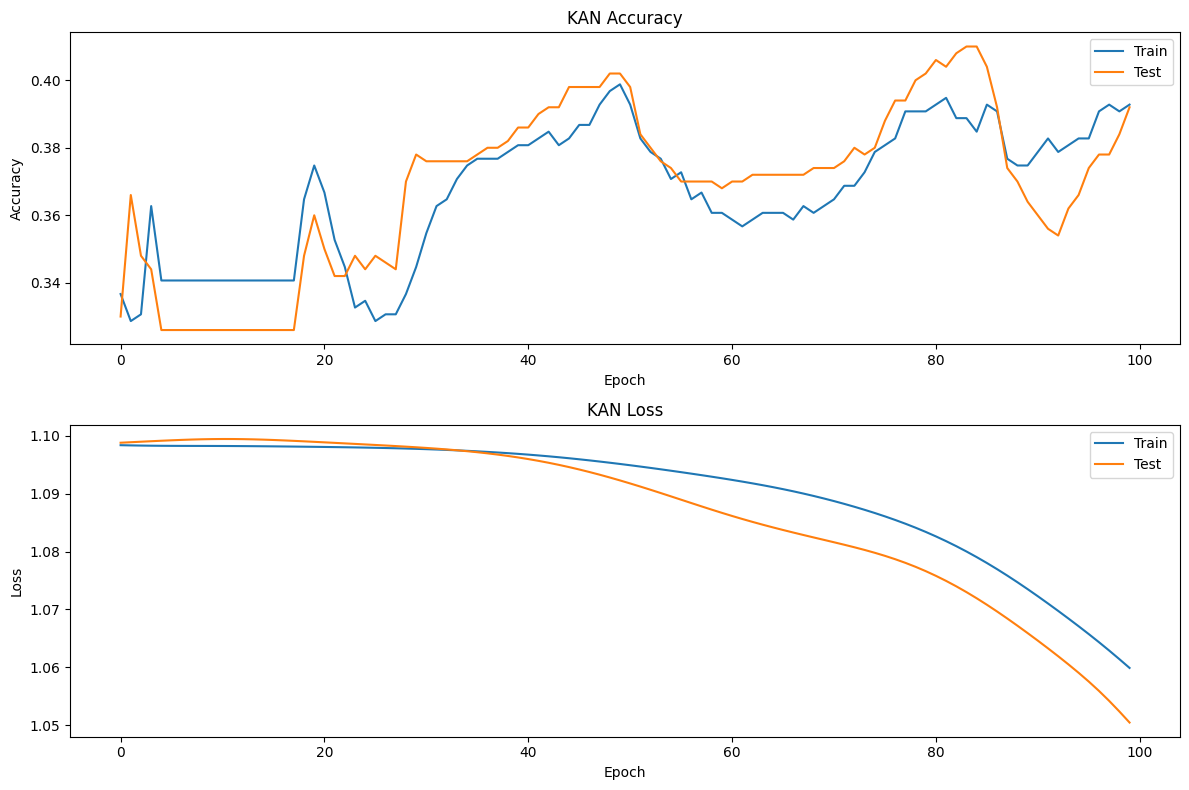

In [ ]:
# Plotting
fig, axs_plot = plt.subplots(2, 1, figsize=(12, 8))

# KAN plots
axs_plot[0].plot(kan_logs['train_accs'], label='Train')
axs_plot[0].plot(kan_logs['test_accs'], label='Test')
axs_plot[0].set_title('KAN Accuracy')
axs_plot[0].set_xlabel('Epoch')
axs_plot[0].set_ylabel('Accuracy')
axs_plot[0].legend()

axs_plot[1].plot(kan_logs['train_loss'], label='Train')
axs_plot[1].plot(kan_logs['test_loss'], label='Test')
axs_plot[1].set_title('KAN Loss')
axs_plot[1].set_xlabel('Epoch')
axs_plot[1].set_ylabel('Loss')
axs_plot[1].legend()

plt.tight_layout()
plt.show()

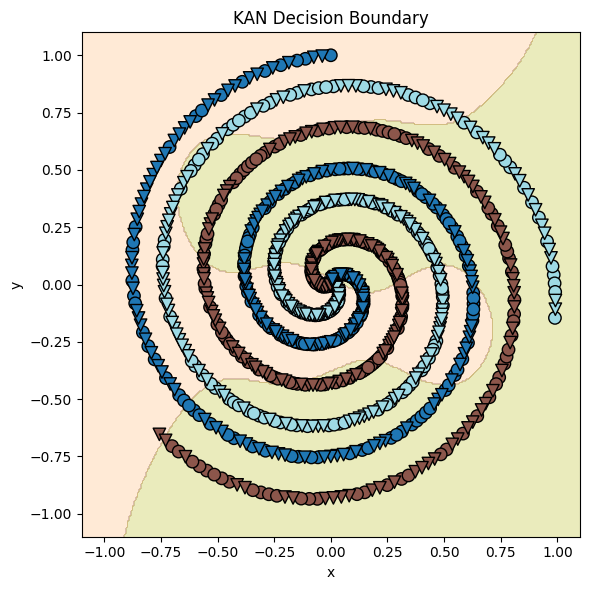

In [ ]:
# Evaluate kan_layerwise on the grid
kan.eval()
with torch.no_grad():
    kan_pred = kan(grid_tensor).argmax(dim=1).cpu().numpy().reshape(xx.shape)

plt.figure(figsize=(6, 6))
plt.contourf(xx, yy, kan_pred, alpha=0.3, levels=n_classes-1, cmap='tab20')
plt.scatter(dataset['train_input'][:, 0].cpu(), dataset['train_input'][:, 1].cpu(), 
            c=dataset['train_label'].cpu(), cmap='tab20', edgecolor='k', s=80, marker='o', label='Train Data (o)')
plt.scatter(dataset['test_input'][:, 0].cpu(), dataset['test_input'][:, 1].cpu(), 
            c=dataset['test_label'].cpu(), cmap='tab20', edgecolor='k', s=80, marker='v', label='Test Data (v)')
plt.title('KAN Decision Boundary')
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()

In [ ]:
print("architecture", architecture)
for i, preacts in enumerate(kan.spline_preacts):
    print(f"Layer {i}: Preactivation shape: {preacts.shape}")

architecture [[2, 0], [5, 0], [5, 0], [5, 0], [5, 0], [5, 0], [3, 0]]
Layer 0: Preactivation shape: torch.Size([90000, 5, 2])
Layer 1: Preactivation shape: torch.Size([90000, 5, 5])
Layer 2: Preactivation shape: torch.Size([90000, 5, 5])
Layer 3: Preactivation shape: torch.Size([90000, 5, 5])
Layer 4: Preactivation shape: torch.Size([90000, 5, 5])
Layer 5: Preactivation shape: torch.Size([90000, 3, 5])
